## 3. Modelling and Conclusion

We will use our cleaned, selectively transformed and dummied features as the X array to craft a Linear Regression (our baseline score). Thanks to the large outliers and skews we saw in EDA, we will opt also for Lasso, Ridge and ElasticNet regression to help regularize the bias. 

The necessary modelling prep, cross-validation and standardization of scaling will also be run.

In [1]:
#we import the usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#but this time we also import split and cross-validation functions
#and standardization, metrics, linear model and regularization functions

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
#reading back in our dataframes

df = pd.read_csv('./datasets/train_clean_log.csv', index_col=False)
test = pd.read_csv('./datasets/test_clean_log.csv', index_col=False)

### Extra Cleaning after Errors

In [3]:
#further down the code, one of our float variables was giving errors in the train_test_split
check_floats = [col for col in df.columns if df[col].dtypes==float]

In [4]:
df[check_floats].describe()

#we have infinite values in our log SF type columns which we will now drop to prevent problem

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area,log_Total Bsmt SF,log_1st Flr SF,log_Year Built,log_Year Remod_Add,log_Yr Sold
count,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,68.885422,98.626524,442.264261,47.935641,567.682838,1057.956850,0.427109,0.063384,1978.682106,1.776694,473.674793,-inf,7.007107,7.586538,7.592910,7.604783
std,21.309886,174.324690,461.094540,164.964052,444.851010,449.303265,0.522589,0.251590,24.213952,0.764367,215.881933,NaN,0.324350,0.015380,0.010628,0.000653
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,-inf,5.811141,7.534763,7.575585,7.603898
25%,60.000000,0.000000,0.000000,0.000000,220.000000,793.000000,0.000000,0.000000,1962.000000,1.000000,319.000000,6.675823,6.779353,7.577378,7.582993,7.604396
50%,68.000000,0.000000,368.000000,0.000000,474.500000,994.500000,0.000000,0.000000,1980.000000,2.000000,480.000000,6.902240,6.996681,7.587817,7.597396,7.604894
75%,78.000000,159.000000,733.500000,0.000000,811.000000,1318.500000,1.000000,0.000000,2001.000000,2.000000,576.000000,7.184250,7.247793,7.601402,7.602900,7.605392
max,313.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,3.000000,2.000000,2010.000000,5.000000,1418.000000,8.717682,8.536015,7.605890,7.605890,7.605890


In [5]:
df.drop(['log_Total Bsmt SF', 'log_1st Flr SF'], axis=1, inplace = True)

In [6]:
#apart from the indexing column errors, PID is an irrelevant metric according to the Data Dictionary 

df.drop(['Unnamed: 0'], axis=1, inplace = True)

In [7]:
test.head()

,Unnamed: 0,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Paved Drive_P,Paved Drive_Y,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,0,190,69.0,9142,6,8,0.0,0.0,0.0,1020.0,...,0,1,0,0,0,0,0,0,0,1
1,1,90,68.0,9662,5,4,0.0,0.0,0.0,1967.0,...,0,1,0,0,0,0,0,0,0,1
2,2,60,58.0,17104,7,5,0.0,554.0,0.0,100.0,...,0,1,0,0,0,0,0,1,0,0
3,3,30,60.0,8520,5,6,0.0,0.0,0.0,968.0,...,0,0,0,0,0,0,0,0,0,1
4,4,20,68.0,9500,6,5,247.0,609.0,0.0,785.0,...,0,1,0,0,0,0,0,0,0,1


In [8]:
test.drop(['log_Total Bsmt SF', 'log_1st Flr SF'], axis=1, inplace = True)
test.drop(['Unnamed: 0'], axis=1, inplace = True)

In [9]:
df['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

In [10]:
df.shape

(2051, 213)

In [11]:
test.shape

(879, 212)

In [28]:
test.head()

#all looks okay

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Paved Drive_P,Paved Drive_Y,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD
0,190,69.0,9142,6,8,0.0,0.0,0.0,1020.0,1020.0,...,0,1,0,0,0,0,0,0,0,1
1,90,68.0,9662,5,4,0.0,0.0,0.0,1967.0,1967.0,...,0,1,0,0,0,0,0,0,0,1
2,60,58.0,17104,7,5,0.0,554.0,0.0,100.0,654.0,...,0,1,0,0,0,0,0,1,0,0
3,30,60.0,8520,5,6,0.0,0.0,0.0,968.0,968.0,...,0,0,0,0,0,0,0,0,0,1
4,20,68.0,9500,6,5,247.0,609.0,0.0,785.0,1394.0,...,0,1,0,0,0,0,0,0,0,1


### Model Prep - Without Feature Selection First

**Every column (that is not our target price) will be used as a predictive feature.**
The `SalePrice` column is our target label: the number of applications received by that university.
We create our `X` feature and `y` target variables below

In [12]:
features = [col for col in df.columns if col != 'SalePrice']

In [13]:
X = df[features]
y = df['SalePrice']

### Train/test split
We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#this means we split up 70% of our train.csv data as the training set, and the other 30% to test.

### Scaling
We apply `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

In [15]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

### Instantiating our models

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV` so we'll need to create instances of all models - starting first with linear regression.

In [16]:
lr = LinearRegression()

### Cross validation and Baseling Scoring without Feature Selection

We use `cross_val_score` to evaluate the linear regression model first.

In [17]:
lr_scores = cross_val_score(lr, X_train_ss, y_train, cv=5)
lr_scores.mean()

-6.87897080548313e+20

The linear regression cross-validation score is so terrible that it is negative. 

This means the model the model I have fit is worse than the null hypothesis, meaning that a straight line with slope of 0 is a better fit than the model I created. 

Since X_train array is using *every single one of our 213 columns in our dataframe indiscriminately,* it is perhaps not surprising that the model is so inaccurate. Accordingly, we must turn to curated feature selection.

### Feature Selection

Recall we already found features we liked from EDA that appeared to have a decent correlation with Sale Price, after observing both their distribution against price and by relying on external research. 

We now refine the feature list to include the dummied variables from EDA, so that the model can run.

In [18]:
categorical_key_features = ['Neighborhood', 'Fireplace Qu', 'Bsmt Qual', 'Exterior 1st']

In [19]:
#search for Neighborhood, Fireplace Qu, Bsmt Qual and Exterior 1st strings

neighborhood_cols = [col for col in df.columns if 'Neighborhood' in col]

neighborhood_cols

['Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_Greens',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker']

In [20]:
fireplace_qu_cols = [col for col in df.columns if 'Fireplace Qu' in col]

fireplace_qu_cols

['Fireplace Qu_Fa',
 'Fireplace Qu_Gd',
 'Fireplace Qu_None',
 'Fireplace Qu_Po',
 'Fireplace Qu_TA']

In [21]:
bsmt_qu_cols = [col for col in df.columns if 'Bsmt Qual' in col]

bsmt_qu_cols

['Bsmt Qual_Fa',
 'Bsmt Qual_Gd',
 'Bsmt Qual_None',
 'Bsmt Qual_Po',
 'Bsmt Qual_TA']

In [22]:
exterior_1st_cols = [col for col in df.columns if 'Exterior 1st' in col]

exterior_1st_cols

['Exterior 1st_AsphShn',
 'Exterior 1st_BrkComm',
 'Exterior 1st_BrkFace',
 'Exterior 1st_CemntBd',
 'Exterior 1st_HdBoard',
 'Exterior 1st_MetalSd',
 'Exterior 1st_Plywood',
 'Exterior 1st_Stucco',
 'Exterior 1st_VinylSd',
 'Exterior 1st_Wd Sdng',
 'Exterior 1st_WdShing']

In [23]:
#building dummy features list

dummy_features = neighborhood_cols + fireplace_qu_cols + bsmt_qu_cols + exterior_1st_cols

df[dummy_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Neighborhood_Blueste  2051 non-null   int64
 1   Neighborhood_BrDale   2051 non-null   int64
 2   Neighborhood_BrkSide  2051 non-null   int64
 3   Neighborhood_ClearCr  2051 non-null   int64
 4   Neighborhood_CollgCr  2051 non-null   int64
 5   Neighborhood_Crawfor  2051 non-null   int64
 6   Neighborhood_Edwards  2051 non-null   int64
 7   Neighborhood_Gilbert  2051 non-null   int64
 8   Neighborhood_Greens   2051 non-null   int64
 9   Neighborhood_IDOTRR   2051 non-null   int64
 10  Neighborhood_MeadowV  2051 non-null   int64
 11  Neighborhood_Mitchel  2051 non-null   int64
 12  Neighborhood_NAmes    2051 non-null   int64
 13  Neighborhood_NPkVill  2051 non-null   int64
 14  Neighborhood_NWAmes   2051 non-null   int64
 15  Neighborhood_NoRidge  2051 non-null   int64
 16  Neighb

In [24]:
best_continuous_features = ['Mas Vnr Area', 'Total Bsmt SF', '1st Flr SF', 
                            'Garage Area', 'Gr Liv Area']

best_discrete_features =['Overall Qual', 'Overall Cond', 'Full Bath', 'Bedroom AbvGr', 
                         'Kitchen AbvGr', 'Fireplaces']

time_features = ['log_Year Built', 'log_Year Remod_Add', 'log_Yr Sold']

In [25]:
#we have now assigned our chosen features into a list that can be used for our models.

chosen_features = best_continuous_features + best_discrete_features + time_features + dummy_features

df[chosen_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Mas Vnr Area,2051.0,98.626524,174.324690,0.000000,0.000000,0.000000,159.000000,1600.00000
Total Bsmt SF,2051.0,1057.956850,449.303265,0.000000,793.000000,994.500000,1318.500000,6110.00000
1st Flr SF,2051.0,1164.488055,396.446923,334.000000,879.500000,1093.000000,1405.000000,5095.00000
Garage Area,2051.0,473.674793,215.881933,0.000000,319.000000,480.000000,576.000000,1418.00000
Gr Liv Area,2051.0,1499.330083,500.447829,334.000000,1129.000000,1444.000000,1728.500000,5642.00000
Overall Qual,2051.0,6.112140,1.426271,1.000000,5.000000,6.000000,7.000000,10.00000
Overall Cond,2051.0,5.562165,1.104497,1.000000,5.000000,5.000000,6.000000,9.00000
Full Bath,2051.0,1.577279,0.549279,0.000000,1.000000,2.000000,2.000000,4.00000
Bedroom AbvGr,2051.0,2.843491,0.826618,0.000000,2.000000,3.000000,3.000000,8.00000
Kitchen AbvGr,2051.0,1.042906,0.209790,0.000000,1.000000,1.000000,1.000000,3.00000


### Linear Regression with Feature Selection: Scores and Evaluation of Predictions

In [26]:
#let's rerun the Linear Regression model with our chosen features

X = df[chosen_features] #New feature matrix with Feature_selection 
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ss = StandardScaler() #standardizing scale again and fitting that scale
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

lr = LinearRegression() #instantiation
lr.fit(X_train_ss, y_train) #fitting the model
y_pred = lr.predict(X_test_ss) 

print('cross validation score', cross_val_score(lr, X_train_ss, y_train, cv=5).mean())
print ('train R2 score ', lr.score(X_train_ss, y_train))
print('test R2 score ', lr.score(X_test_ss, y_test))
print('RMSE: ', mean_squared_error(y_test, y_pred)**0.5, 0)

cross validation score 0.8355844669168123
train R2 score  0.869727411507565
test R2 score  0.8276468636192799
RMSE:  33569.079709314785 0


With our feature-focused model, our train and test scores are really good, with 84% of our model fitting into the test data. Our Root Mean Squared Error also demonstrates that we are within +/- $32,195 of the true sale price. 

Recalling from EDA that standard deviation of actual prices is $79,258, the RMSE is actually quite low at less than half of that value.

The cross-validation score is also positive, thankfully, at 83.5% of modelling accuracy for unseen values.

Let's create a coefficient table matrix to understand what coefficients have a strong factor.

**Our baseline score, R2, is therefore quite high at 0.86 - the nearer to 1, the better because it means our model's predicted price can account for 86% of the true price.**

In [29]:
#calling out linear regression coeffs

lr.coef_

array([  3931.36849825,   5949.93107769,   5036.05868819,   6994.7539697 ,
        20365.20345217,  14935.10406961,   7237.35943602,   2168.98755601,
        -2668.52914728,  -3589.37820815,   3791.51986706,   8300.48043262,
         2297.14206005,  -1125.12551409,   -734.20821142,  -2042.34645099,
          509.95020135,   1535.01845182,   2813.49639195,   4277.23932296,
        -1642.3985101 ,   1843.59812727,   -100.9536497 ,   -618.29386419,
        -2556.71294315,    553.21171742,    551.48407988,  -1051.25515239,
         -590.03216473,   6601.49354772,   7489.67567456,  -1750.42003429,
         -546.58252028,   1291.55485875,   1127.68054468,   2769.08803016,
         6121.88625394,   2692.51890466,   1279.78254089,  -2615.97826967,
        -6588.33646366,  -8855.01265164,  -2090.20468476,  -6610.89742892,
        -8106.91975099, -24475.64645333,  -7897.96050664,  -1318.71096725,
       -25179.64625931,   1014.04803525,  -1299.66636614,   3339.60151359,
         2299.17108924,  

In [33]:
coefficient_table = pd.DataFrame(lr.coef_, X.columns, columns = ['Coefficients'])

In [71]:
coefficient_table.sort_values('Coefficients', ascending = False).head(5)

,Coefficients
Gr Liv Area,20365.203452
Overall Qual,14935.104070
log_Year Built,8300.480433
Neighborhood_NridgHt,7489.675675
Overall Cond,7237.359436


In corroboration with our EDA and External Research, we see that the top 5 coefficients all relate to:

1. Above Ground Living Area (at a whopping 20,000+ valued coefficient)
2. Overall House Quality (material and finish)
3. When the House was Built
4. Whether its in the Neighbourhood of Northridge Heights
5. The Overall Condition of the House (overall condition)

So once again the house size matters, neighbourhood matters, when the house was built matters, as does the overall condition of the house. 

If we look at a plot of our predictions vs the actual price, here's what we get:

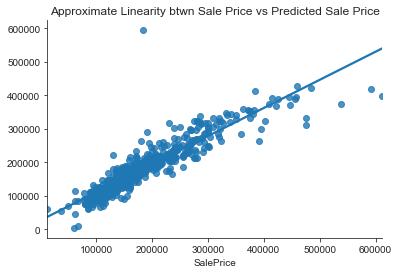

In [56]:
sns.set_style('ticks')
sns.regplot(y_test, y_pred, ci=None).set_title("Approximate Linearity btwn Sale Price vs Predicted Sale Price")
sns.despine()  

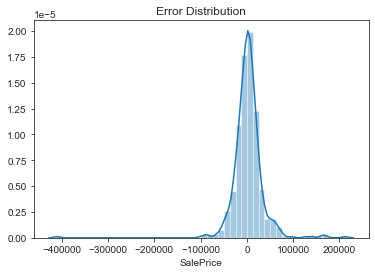

In [55]:
sns.distplot((y_test - y_pred)).set_title('Error Distribution');

These graphs show us that our Sale Price predictions are pretty collinear with the actual sale price. Our errors are also distributed normally, with a median and mean value that visually looks right down 0 (so mostly zero error) with only a handful of outliers. Overall, its therefore quite a good model.

### Lasso Regression with Feature Selection: Scores and Evaluation of Predictions

`LassoCV` is our next model to check out so let's move forward with that model. We fit the model to the training data, and evaluate the training and test scores below again:

In [62]:
X = df[chosen_features] #New feature matrix with Feature_selection 
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ss = StandardScaler() #standardizing scale again and fitting that scale
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

lasso_model = LassoCV(cv=5) #instantiating lasso
lasso_model.fit(X_train_ss, y_train) #fitting lasso 
            
lasso = Lasso(alpha = lasso_model.alpha_) #determining alpha
lasso.fit(X_train_ss, y_train)
    
# Generate predictions
lasso_preds = lasso.predict(X_test_ss)
lasso_preds_train = lasso.predict(X_train_ss)

print('cross validation score', cross_val_score(lasso, X_train_ss, y_train, cv=5).mean())
print ('train R2 score ', lasso.score(X_train_ss, y_train))
print('test R2 score ', lasso.score(X_test_ss, y_test))
print('RMSE: ', mean_squared_error(y_test, y_pred)**0.5, 0)
print('best alpha: ', lasso_model.alpha_)

cross validation score 0.8185969421488595
train R2 score  0.8509481150471381
test R2 score  0.8652071905719976
RMSE:  108263.37040458339 0
best alpha:  268.7745408920981


With our feature-focused Lasso model, our train and test scores are still really good, both being higher than 85%.

However, our Root Mean Squared Error rises signifcantly; we are within +/- $107,949 of the true sale price - a far higher margin of error than the standard linear regression model above.

Recalling from EDA that our standard deviation is $79,258, this means the RMSE is actually so high that you could see as much as an error equivalent to 1.3 standard deviations from the mean price, which means its really not that accurate at all.

Let's create a coefficient table matrix to understand what coefficients have a strong factor.

In [63]:
lasso_coefficient_table = pd.DataFrame(lasso.coef_, X.columns, columns = ['Coefficients'])

In [72]:
lasso_coefficient_table.sort_values('Coefficients', ascending = False).head(5)

,Coefficients
Overall Qual,17715.454057
Gr Liv Area,17608.536773
Neighborhood_NridgHt,8782.215841
Garage Area,8022.422564
Neighborhood_NoRidge,7578.477038


Once again, in corroboration with our EDA and External Research, we see that the top 5 coefficients all relate to the same things we thought to be important, except with Lasso, the model places increased importance on the Garage Area, and another important neighbourhood known as Stone Brook:

1. Overall House Quality (material and finish) - same as Linear Regression model
2. Above Ground Living Area (at a whopping 20,000+ valued coefficient)
3. Whether House is in the Neighbourhood of Northridge Heights
4. The Garage Area
5. Whether House is in the Neighbourhood of Stone Brook

Let's plot graphs of the error residuals again:

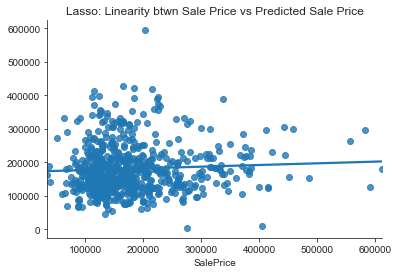

In [65]:
sns.set_style('ticks')
sns.regplot(y_test, y_pred, ci=None).set_title("Lasso: Linearity btwn Sale Price vs Predicted Sale Price")
sns.despine()  

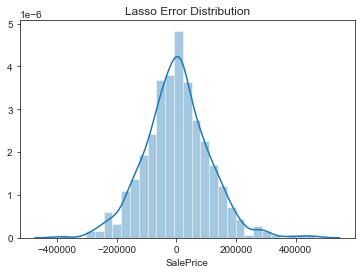

In [66]:
sns.distplot((y_test - y_pred)).set_title('Lasso Error Distribution');

These graphs show us that while the error distribution is normal/Gaussian, the predictions a have a weaker correlation with the majority of accurate predictions clustered around the $100,000-200,000 price mark. 

**It is clearly a poorer predictive model compared to our Linear Regression model above.**

In [ ]:
### Ridge Regression with Feature Selection: Scores and Evaluation of Predictions

`RidgeCV` is our next model to check out so let's move forward with that model. We fit the model to the training data, and evaluate the training and test scores below again:

In [67]:
X = df[chosen_features] #New feature matrix with Feature_selection 
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ss = StandardScaler() #standardizing scale again and fitting that scale
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

ridge_model = RidgeCV(cv=5) #instantiating ridge
ridge_model.fit(X_train_ss, y_train) #fitting ridge 
            
ridge = Ridge(alpha = ridge_model.alpha_) #determining alpha
ridge.fit(X_train_ss, y_train)
    
# Generate predictions
ridge_preds = ridge.predict(X_test_ss)
ridge_preds_train = lasso.predict(X_train_ss)

print('cross validation score', cross_val_score(ridge, X_train_ss, y_train, cv=5).mean())
print ('train R2 score ', ridge.score(X_train_ss, y_train))
print('test R2 score ', ridge.score(X_test_ss, y_test))
print('RMSE: ', mean_squared_error(y_test, y_pred)**0.5, 0)
print('best alpha: ', ridge_model.alpha_)

cross validation score 0.8388264710721283
train R2 score  0.8735345913004813
test R2 score  0.8173503626947997
RMSE:  107945.79657884658 0
best alpha:  10.0


With our feature-focused Ridge model, our train and test scores are still good, but the train R2 score is much higher than test,
indicating weaker predictive modeling than either Lasso or Ridge.

Like the Lasso model, the Ridge Root Mean Squared Error rises signifcantly compared to Linear Regression and has a very similar RMSE; we are within +/- $107,945 of the true sale price - a far higher margin of error than the standard linear regression model above and once again translating to about 1.3 standard deviations from the mean price.

Let's create a coefficient table matrix to understand what coefficients have a strong factor.

In [68]:
ridge_coefficient_table = pd.DataFrame(ridge.coef_, X.columns, columns = ['Coefficients'])

In [74]:
ridge_coefficient_table.sort_values('Coefficients', ascending = False).head(5)

,Coefficients
Gr Liv Area,21541.523216
Overall Qual,13297.895792
Total Bsmt SF,10664.946449
log_Year Built,9240.209226
Fireplaces,9186.478807


Once again, in corroboration with our EDA and External Research, we see that the top 5 coefficients all relate to the same things we thought to be important, except with Ridge Regression, the model places increased importance on the square footage realted metrics, and house age and the number of fireplaces. Interestingly Ridge Regression's top 5 coefficients care less about neighbourhoods:

1. Above Ground Living Area (at a whopping 20,000+ valued coefficient)
2. Overall House Quality (material and finish) - same as Lasso and Linear Regression models 
3. Total Basement Square Footage
4. When the House was Built
5. How many fireplaces there are

Let's plot graphs of the error residuals for Ridge:

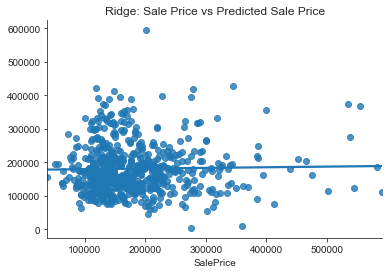

In [76]:
sns.set_style('ticks')
sns.regplot(y_test, y_pred, ci=None).set_title("Ridge: Sale Price vs Predicted Sale Price")
sns.despine()  

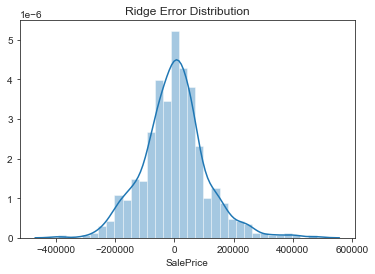

In [77]:
sns.distplot((y_test - y_pred)).set_title('Ridge Error Distribution');


The Ridge error distribution and residual graphs are similar to Lasso, although the normality of error distribution with Ridge is less normally distributed than Lasso above.

Again, the predictions ahave a weaker linear correlation with the majority of accurate predictions clustered around the $100,000-200,000 price mark. 


Like Lasso, within that range, the values are clustered together, which indicate reduced variance, but because so many points fall far below the baseline, this indicates that the data is quite biased. Beyond roughly the 200,000 mark, The model is therefore ** underfit **.

Although 

**It is also clearly a poorer predictive model compared to our Linear Regression model above.**

## Conclusions

### Summary
Let's recap the problem statement again:

**Can we help real estate agents in the city of Ames, Iowa predict the sale price of a house based on housing and real estate data using key predictors to create an accessible predictive Regression-based model?**

The answer is **yes**. Here's what we did:

* In evaluating the Ames housing datasets, we went through a very challenging cleaning process thanks to the very large number of columns, null values, and categories. These categories were later one-hot encoded in order to become machine-readable in binary terms. 

* We then explored the trends of the data itself, and found that the best predictors were those which related to:

    1. Suburb/Neighbourhood

    2. Additions and Upgrades: e.g. Fireplaces and Basement Categories

    3. Time - Age of House

    4. Quality and Condition: External Materials Quality 

    5. Size of House: we already have covered continuous square footage earlier, but there's also MS SubClass
    
* We justified with research and considerations of our practical, commercial audience (real estate agents) that not every category of predictor is going to be somethig of interest to them, and so we did some feature selection based on our 5 factors above.

* External sources corroborate the same: 
https://www.propertyguru.com.my/property-guides/10-factors-impact-property-value-malaysia-13228
https://www.redbrick.sg/blog/what-affects-real-estate-prices/

* Using these best predictors, we then instantiated, fitted and ran predictive models using Linear, Lasso and Ridge Regression.

Based on our comparative evaluation of the quality of each of the three models, **Linear Regression has the best predictive model.** 

**We will recommend the baseline model to our stakeholders** - this is because it performs the best out of the 3. The spread of errors and the collinearity between predicted sale prices and actual sale prices is strong, and the Root Mean Squared Error is ~$32,000, whilst Ridge and Lasso are more than 3 times as much. 

### Linear Regression as our choice: Pros, Cons, & Solutions



We already know that our error variables are pretty good for the Linear Regression model. 

The advantages of Linear Regression models are that they are easy to implement when data is linearly separable, but can be underfit when the data isn't. Thankfully, our cross-validations and feature selection have helpfully rendered bias and variance to low levels, but of course it comes at the cost of sophistication since we have reduced the relative types of features used to predict.


As far as predicting prices for real estate is goes, the data itself is also quite limited. The reasons are summarized here:

* Economic Conditions are not accounted for - it's well known that prices of houses tend to inflate in growth economies and contract during deflation. Prevailing central bank interest rates are also not accounted for - when these are low, people are more likely to take out mortgages to finance the purchase of property.

* The features of the neighbourhood itself: We don't know anything about whether the houses are near popular amenities and facilities like shopping centres, schools or attractions. There are entries like "Condition 1" which describes proximity to railroads and parks, but in reality people look at so much more than - people buy homes based on what the neighbourhood offers too, and not just the house itself.

* Data is only up between 2006 - 2010 - of course much has happened since then and we are an entire decade away from that. Prices have no doubt changed a lot since then. In our data, the mean price is about $180,000; research shows that current mean price is about $229,000: https://www.zillow.com/ames-ia/home-values/; or as much as a 49% increase!

* Appearance/Architecture: people also buy houses based on aesthetics - the value of a house is also impacted by how pretty it looks architecturally. Our data says nothing about this, and only talks about Ms SubClass - which only indicates utilitarian concerns e.g. if a property is a 2 storey for families.

* Investment Potential: there is also no data on how much rent can be commanded by each house. The rate of return on rent is a big factor for housing prices, as high-rent properties can command higher prices due to the return on investment.

* There is nothing about energy saving features like solar panels. Although heating is discussed, energy-cost saving features aren't in the dataframe. Given that Ames can go as low as -10 degrees celsius in colder months, this would arguably be an important factor. 

Sources: 
https://www.bestplaces.net/climate/city/iowa/ames
https://weatherspark.com/y/10339/Average-Weather-in-Ames-Iowa-United-States-Year-Round
https://www.finder.com.au/what-influences-a-propertys-value

Thankfully, our stakeholders, real estate agents, can address most of these things by simply doing what they already know best. 

Real estate agents already have to inspect properties thoroughly and use their own judgement to evaluate whether a property is of better value based on what the amenities in the neighbourhood are like, how it looks, and if there are any energy saving features to pitch to clients e.g. solar panels.

If newer data can be supplied, the model can be even more useful. Real estate agents can then rely on our data as a benchmark, before applying their own professional judgement in assessing whether what their own inspections and research could add or subtract from our own predicted estimates.


In this way, our model, when combined with the professional judgement of our stakeholders, can be used to support them in their work by predicting prices

## 4. Kaggle Linear Regression Submission

Now all that's left to do is to submit this to Kaggle:

In [111]:
pwd

'/Users/grahamlim/Documents/DSI15/lab_projects_copy/project_2/datasets'

In [112]:
lr = LinearRegression() #instantiate again 

X = df[chosen_features] #same arrays
y = df['SalePrice']

lr.fit(X, y) #fitting model

test_preds = lr.predict(test[chosen_features])

samplesubmission = pd.read_csv('./datasets/sample_sub_reg.csv')

output = pd.DataFrame({'Id': samplesubmission.Id, 'SalePrice': test_preds})
output.to_csv('submitted.csv', index=False)#outputting submitted.csv with Id index column complying with sample's format